# 작사가 만들기 프로젝트

## 데이터 다운로드
 wget https://aiffelstaticprd.blob.core.windows.net/media/documents/song_lyrics.zip

## 데이터 읽어오기

In [1]:
import glob
import os

txt_file_path = 'data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['The Cat in the Hat', 'By Dr. Seuss', 'The sun did not shine.']


## 데이터 정제
preprocess_sentence() 함수를 활용해 데이터 정제

추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거합니다.

문장을 토큰화 했을 때 토큰의 개수가 15개를 넘어가면 잘라내기를 권합니다.

In [2]:
import re            
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()       # 소문자로 바꾸고 양쪽 공백을 삭제
  
    # 아래 3단계를 거쳐 sentence는 스페이스 1개를 delimeter로 하는 소문자 단어 시퀀스로 바뀝니다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)        # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                  # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)  # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환

    sentence = sentence.strip()

    sentence = '<start> ' + sentence + ' <end>'      # 이전 스텝에서 본 것처럼 문장 앞뒤로 <start>와 <end>를 단어처럼 붙여 줍니다
    
    return sentence

In [3]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> the cat in the hat <end>',
 '<start> by dr . seuss <end>',
 '<start> the sun did not shine . <end>',
 '<start> it was too wet to play . <end>',
 '<start> so we sat in the house <end>',
 '<start> all that cold cold wet day . <end>',
 '<start> i sat there with sally . <end>',
 '<start> we sat there we two . <end>',
 '<start> and i said how i wish <end>',
 '<start> we had something to do ! <end>']

In [4]:
import tensorflow as tf
def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,  # 전체 단어의 개수 
        filters=' ',    # 별도로 전처리 로직을 추가할 수 있습니다. 이번에는 사용하지 않겠습니다.
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 됩니다.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   
    # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.

    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  

    print(tensor,tokenizer)
    return tensor, tokenizer
tensor, tokenizer = tokenize(corpus)

[[   2    6  903 ...    0    0    0]
 [   2  122 2584 ...    0    0    0]
 [   2    6  304 ...    0    0    0]
 ...
 [ 673   27    6 ...    6  189    3]
 [   2  673   27 ...    0    0    0]
 [   2  673   27 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7faf7d1d03d0>


In [5]:
print(tensor[:3, :15])

[[   2    6  903   14    6 1350    3    0    0    0    0    0    0    0
     0]
 [   2  122 2584   20    1    3    0    0    0    0    0    0    0    0
     0]
 [   2    6  304  166   70  559   20    3    0    0    0    0    0    0
     0]]


In [6]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [8]:
src_input = tensor[:, :-1]  # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다. 마지막 토큰은 <END>가 아니라 <pad>일 가능성이 높습니다.
tgt_input = tensor[:, 1:]    # tensor에서 <START>를 잘라내서 타겟 문장을 생성합니다.

print(src_input[0])
print(tgt_input[0])

[   2    6  903   14    6 1350    3    0    0    0    0    0    0    0]
[   6  903   14    6 1350    3    0    0    0    0    0    0    0    0]


## 평가 데이터셋 분리
**훈련 데이터와 평가 데이터를 분리하세요!**

`tokenize()` 함수로 데이터를 Tensor로 변환한 후, `sklearn` 모듈의 `train_test_split()`

함수를 사용해 훈련 데이터와 평가 데이터를 분리하도록 하겠습니다. 

단어장의 크기는 12,000 이상으로 설정하세요!

총 데이터의 20%를 평가 데이터셋으로 사용해 주세요!

In [9]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=34)

In [10]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   
# tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

In [12]:
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

## 인공지능 만들기
모델의 Embedding Size와 Hidden Size를 조절하며 

10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계하세요! 

(Loss는 아래 제시된 Loss 함수를 그대로 사용!)


`loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')`

In [13]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.drop1 = tf.keras.layers.Dropout(0.3)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.drop1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 1024
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [14]:
for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-3.39950755e-04,  9.62374615e-04,  6.44276734e-05, ...,
         -5.62458648e-04, -1.57038870e-04, -7.08163599e-04],
        [-5.91338088e-04,  1.70278619e-03, -5.14362473e-04, ...,
         -5.61500317e-04, -6.18121587e-04, -1.11529650e-03],
        [-9.02707805e-04,  1.88881985e-03, -1.16728444e-03, ...,
         -7.06479303e-04, -9.98015516e-04, -1.33103225e-03],
        ...,
        [-2.57130538e-04,  6.56609016e-04, -1.92270672e-03, ...,
         -1.31871016e-03, -2.33072788e-03,  1.23617670e-03],
        [-2.41459275e-04,  4.00909455e-04, -2.56170239e-03, ...,
         -1.56585500e-03, -2.46286090e-03,  1.88458839e-03],
        [-3.22943961e-04,  1.11753623e-04, -3.23991245e-03, ...,
         -1.77496637e-03, -2.56651733e-03,  2.47097248e-03]],

       [[-3.39950755e-04,  9.62374615e-04,  6.44276734e-05, ...,
         -5.62458648e-04, -1.57038870e-04, -7.08163599e-04],
        [-8.45975941e-04,  7.75889610e-04,  4

In [15]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  12289024  
_________________________________________________________________
lstm (LSTM)                  multiple                  25174016  
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense (Dense)                multiple                  24590049  
Total params: 95,615,713
Trainable params: 95,615,713
Non-trainable params: 0
_________________________________________________________________


In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [22]:
history = []
epochs = 10
history = model.fit(dataset,
          epochs=epochs,
          batch_size=256,
          validation_data=val_dataset,
          verbose=1)

Epoch 1/10
549/549 [==============================] - 331s 604ms/step - loss: 3.4846 - accuracy: 0.4667 - val_loss: 3.0684 - val_accuracy: 0.4995
Epoch 2/10
549/549 [==============================] - 331s 603ms/step - loss: 2.9102 - accuracy: 0.5100 - val_loss: 2.8112 - val_accuracy: 0.5224
Epoch 3/10
549/549 [==============================] - 308s 561ms/step - loss: 2.6134 - accuracy: 0.5352 - val_loss: 2.6417 - val_accuracy: 0.5422
Epoch 4/10
549/549 [==============================] - 289s 527ms/step - loss: 2.3408 - accuracy: 0.5644 - val_loss: 2.5125 - val_accuracy: 0.5631
Epoch 5/10
549/549 [==============================] - 337s 615ms/step - loss: 2.0864 - accuracy: 0.5977 - val_loss: 2.4174 - val_accuracy: 0.5824
Epoch 6/10
549/549 [==============================] - 311s 566ms/step - loss: 1.8559 - accuracy: 0.6332 - val_loss: 2.3535 - val_accuracy: 0.5978
Epoch 7/10
549/549 [==============================] - 307s 559ms/step - loss: 1.6551 - accuracy: 0.6679 - val_loss: 2.3126 -

In [23]:

def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

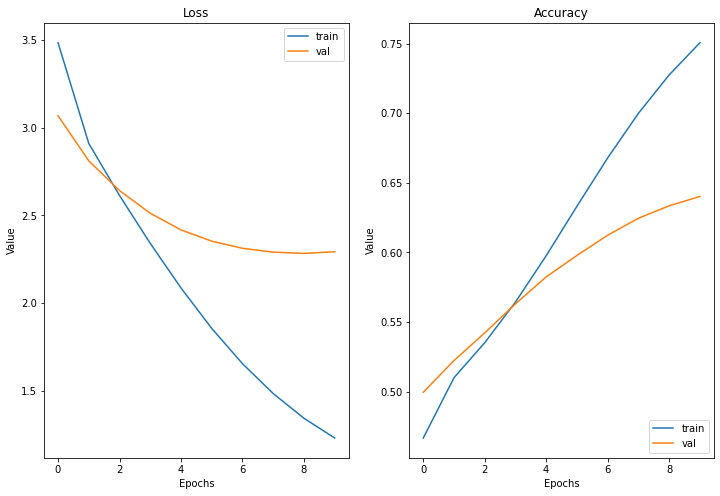

In [25]:
import matplotlib.pyplot as plt 
plot_curve(history.epoch, history.history,
           ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [26]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, 
        tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <END>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

## Generate lyrics

In [27]:
generate_text(model, tokenizer, init_sentence="<start> i will", max_len=20)

'<start> i will eat you alive <end> '

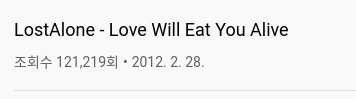
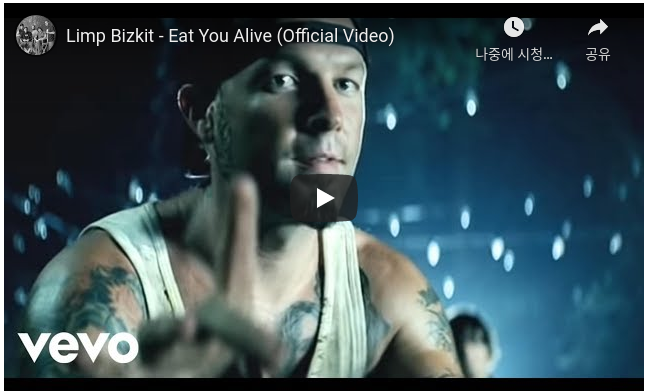

In [28]:
generate_text(model, tokenizer, init_sentence="<start> she was", max_len=20)

'<start> she was like whoa whoa whoa whoa whoa whoa whoa whoa <end> '

In [38]:
generate_text(model, tokenizer, init_sentence="<start> you", max_len=20)

'<start> you know i m bad , i m bad you know it <end> '

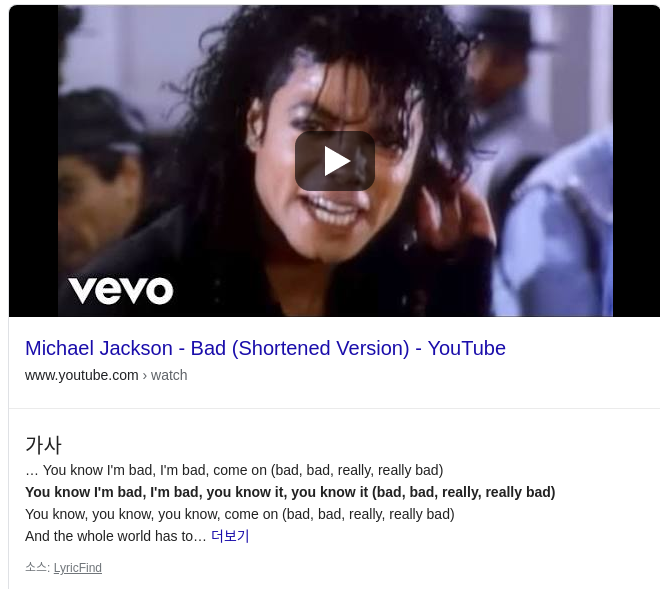

## 마무리
처음 실습 모델 그대로 해봤는데 val_loss 값이 2.6 정도 였습니다. 기존 실습 데이터보다 양이 많다고 판단해서

LSTM Layer 중간에 Dropout 30%을 적용했습니다.

Embedding, hidden Size도 높게 조정하여 큰 데이터에 잘 대응할 수 있도록 적용했습니다.

문자열 처리 모델이 이미지 처리모델보다 파라미터 수가 많은 것 같습니다

이번 노드를 진행하며

GLP-3 모델에 대한 자료를 찾아보며 공부해보고 싶다는 생각이 들었습니다

작사가 답게 검색해보면 비슷한 가사가 잘 나오는 것을 보고 신기하다고 생각했다.